# MC030 - Projeto final de Graduação
## Análise e Previsão do Mercado de Ações

## Descrição do modelo

A partir de um conjunto de cotações diárias de dólar para real (USD-BRL) desejamos modelar esse comportamento a partir de uma série de indicadores de mercado financeiro para classificarmos cada dia como um momento de compra ou momento de venda.

# ...

# Código

### Definindo endpoints da API (https://www.alphavantage.co/documentation/)

In [1]:
apiToken = '3GX5M109KQK9B6HO'
baseUrl = 'https://www.alphavantage.co/query?&outputsize=full&apikey=' + apiToken
usdBrlUrl = 'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol=USD&to_symbol=BRL&outputsize=full&apikey=' + apiToken
stockUrl = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&outputsize=full&apikey=demo'

### Obtendo dados da API

In [2]:
import requests
import json
import time

callsMade = 0

def incrementAndVerifyCallsMade():
    global callsMade
    if callsMade == 5:
        print('Made 5 requests to the API in the last minute - sleeping for 1 minute')
        time.sleep(65)
        callsMade = 0
    callsMade += 1

def parsePriceRetrieved(stocksRetrieved):
    stockPrices = {}
    for date, candle in stocksRetrieved.items():
        stockPrices[date] = candle['1. open']
    return stockPrices
    
def parseIndicatorRetrieved(indicatorsRetrieved):
    indicatorValues = {}
    for date, indicator in indicatorsRetrieved.items():
        for indicatorSymbol, indicatorValue in indicator.items():
            indicatorValues[date] = {indicatorSymbol: indicatorValue}
    return indicatorValues

# returns [{date: price}]
def getStockPrice(stockSymbol):
    stockUrl = baseUrl + '&function=TIME_SERIES_DAILY&symbol=' + stockSymbol
    print('Fetching ' + stockUrl)
    incrementAndVerifyCallsMade()
    stocksRetrieved = requests.get(stockUrl).json();
    stocks = parsePriceRetrieved(stocksRetrieved['Time Series (Daily)'])
    print('Retrieved and parsed '+ stockUrl)
    return stocks

# returns [{date: price}]
def getForexPrice(fromSymbol, toSymbol):
    forexUrl = baseUrl + '&function=FX_DAILY&from_symbol=' + fromSymbol + '&to_symbol=' + toSymbol
    print('Fetching ' + forexUrl)
    incrementAndVerifyCallsMade()
    forexRetrieved = requests.get(forexUrl).json();
    forex = parsePriceRetrieved(forexRetrieved)
    print('Retrieved and parsed '+ forexUrl)
    return forex

# returns [date: [{indicatorFunction: indicatorValue}]]
def getIndicator(indicatorFunction, symbol):
    indicatorUrl = baseUrl + '&interval=daily&series_type=open&function=' + indicatorFunction + '&symbol=' + symbol
    if indicatorFunction=='SMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='EMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='WMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='DEMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='TEMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='TRIMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='KAMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='MAMA':
        indicatorUrl += '&fastlimit=0.01&slowlimit=0.01'
    elif indicatorFunction=='T3':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='MACD':
        indicatorUrl += '&fastperiod=12&slowperiod=26&signalperiod=9'
    elif indicatorFunction=='MACDEXT':
        indicatorUrl += '&fastperiod=12&slowperiod=26&signalperiod=9&fastmatype=0&slowmatype=0&signalmatype=0'
    # TODO: terminar isso aqi
    print('Fetching ' + indicatorUrl)
    incrementAndVerifyCallsMade();
    indicatorRetrieved = requests.get(indicatorUrl).json()
    indicators = parseIndicatorRetrieved(indicatorRetrieved['Technical Analysis: ' + indicatorFunction])
    print('Retrieved and parsed '+ indicatorUrl)
    return indicators

# returns [date: [{indicatorFunction: indicatorValue}]]
def getIndicatorList(indicatorFunctions, symbol):
    indicators = {}
    for indicatorFunction in indicatorFunctions:
        indicatorDict = getIndicator(indicatorFunction, symbol)
        for date, indicator in indicatorDict.items():
            for indicatorFunction, indicatorValue in indicator.items():
                if  date not in indicators:
                    indicators[date] = {}
                indicators[date][indicatorFunction] = indicatorValue
    return indicators

In [3]:
# Filtrando dados válidos - apenas aqueles cujas datas estão na lista de preços e de indicadores
def filterData(prices, indicators):
    filteredPrices = {date: price for date, price in prices.items() if date in indicators.keys()}
    filteredIndicators = {date: indicators for date, indicators in indicators.items() if date in prices.keys()}
    return filteredPrices, filteredIndicators


def getData(stockSymbol, indicatorFunctions):
    stockPrices = getStockPrice(stockSymbol)
    indicators = getIndicatorList(indicatorFunctions, stockSymbol)
    stockPrices, indicators = filterData(stockPrices, indicators)
    return stockPrices, indicators

def getForexData(fromForexSymbol, toForexSymbol, indicatorFunctions):
    forexPrices = getForexPrice(fromForexSymbol, toForexSymbol)
    indicators = getIndicatorList(indicatorFunctions, fromForexSymbol + toForexSymbol)
    forexPrices, indicators = filterData(forexPrices, indicators)
    return forexPrices, indicators

### Métodos de anotação de dados

In [4]:
import collections

def annotateBuyOrSell(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    earlierDate = ''
    last = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = value
        break
    for date, price in prices.items():
        if price > yesterdayPrice:
            dateAnnotated[yesterdayDate] = 'B'
            last = 'B'
        elif price < yesterdayPrice:
            dateAnnotated[yesterdayDate] = 'S'
            last = 'S'
        else:
            dateAnnotated[yesterdayDate] = last
        yesterdayDate = date
        yesterdayPrice = price
    return dateAnnotated

def annotateMaxProfit(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    yesterdayPrice = 0
    currentStatus = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = value
        break
    for date, price in prices.items():
        if price > yesterdayPrice and currentStatus != 'B':
            dateAnnotated[yesterdayDate] = 'B'
            currentStatus = 'B'
        elif price < yesterdayPrice and currentStatus != 'S':
            dateAnnotated[yesterdayDate] = 'S'
            currentStatus = 'S'
        yesterdayDate = date
        yesterdayPrice = price
    return dateAnnotated

### Normalização dos dados

In [5]:
# Dúvida - como faremos a normalização?
# Ideia: normalizarmos de acordo com o preço da ação no momento

# Exemplo: temos o valor de uma ação atualmente em R$3.00, mas sua média dos últimos 10 dias é de R$2.90,
# logo esta ação está aumentando de valor. Se normalizarmos todos os indicadores de acordo com o preço atual
# da ação podemos ter mais sucesso, pois no momento de atuação do modelo tudo que ele terá acesso será o preço 
# atual da ação e seus indicadores... Normalizar de acordo com um teto e piso de valores acho que pode dar ruim.

import copy

# Normaliza um conjunto de indicadores a partir do preço da ação
def normalizeIndicators(indicatorSet, stockPrice):
    normalizedIndicatorSet = {}
    for indicatorFunction, indicatorValue in indicatorSet.items():
        normalizedIndicatorSet[indicatorFunction] = float(indicatorValue)/float(stockPrice)
    return normalizedIndicatorSet

# Retorna os indicadores normalizados: indicadores = [date: {indicators: ['SMA': 0.89, 'EMA': 0.93], annotation: 'B'}]
def getIndicatorsNormalizedAndAnnotaded(stockPrices, indicators, dateAnnotated):
    print('Normalizing and annotating indicators')
    indicatorsAnnotated = {}
    for date, annotation in dateAnnotated.items():
        if date not in indicatorsAnnotated:
            indicatorsAnnotated[date] = {'indicators': {}, 'annotation': ''}
        indicatorsAnnotated[date]['indicators'] = normalizeIndicators(indicators[date], stockPrices[date])
        indicatorsAnnotated[date]['annotation'] = annotation
    return indicatorsAnnotated

# Deprecated
def normalizeIndicatorsOld(indicatorsAnnotated):
    normalizedIndicators = {'B': [], 'S': []}
    for indicatorSet in indicatorsAnnotated['B']:
        normalizedIndicatorSet = []
        for indicator, value in indicatorSet.items():
            print(indicator)
            normalizedIndicatorSet.append({indicator: value/1000})
        normalizedIndicators[B].append(normalizedIndicatorSet)
    for indicators in indicatorsAnnotated['S']:
        print(indicators)

### Machine Learning

In [47]:
import keras

def getModelLSTM(n_steps, n_features):    
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(64, activation='relu', input_shape=(n_steps, n_features)))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def getModelBidirectionalLSTM(n_steps, n_features):    
    model = keras.models.Sequential()
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, activation='relu'), input_shape=(n_steps, n_features)))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def getModelCNN(n_steps, n_features):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
#     model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Análise de dados

In [7]:
def analyze(analytics):
    print('some analytics')

### Main

In [8]:
# Cheat-sheet com os simbolos
__indicatorSymbols = ['SMA', 'EMA', 'WMA', 'DEMA', 'TEMA', 'TRIMA', 'KAMA', 'MAMA',
                      'T3', 'MACD', 'MACDEXT', 'STOCH', 'STOCHF', 'RSI', 'STOCHRSI', 'WILLR', 
                      'ADX', 'ADXR', 'APO', 'PPO', 'MOM', 'BOP', 'CCI', 'CMO', 'ROC', 'ROCR',
                      'AROON', 'AROONOSC', 'MFI', 'TRIX', 'ULTOSC', 'DX', 'MINUS_DI', 'PLUS_DI',
                      'MINUS_DM', 'PLUS_DM', 'BBANDS', 'MIDPOINT', 'SAR', 'TRANGE', 'ATR',
                      'NATR', 'AD', 'ADOSC', 'OBV', 'HT_TRENDLINE', 'HT_SINE', 'HT_TRENDMODE',
                      'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR']
__forexSymbols = ['BRL', 'EUR']
__stockSymbols = ['MSFT']

# Definindo simbolos para o modelo
indicatorFunctions = ['SMA', 'EMA', 'WMA']
# fromForexSymbol = 'USD'
# toForexSymbol = 'BRL'
stockSymbol = 'MSFT'

stockPrices, indicators = getData(stockSymbol, indicatorFunctions)
# forexPrices, indicators = getForexData(fromForexSymbol, toForexSymbol, indicatorFunctions)
dateAnnotated = annotateBuyOrSell(stockPrices)
# dateAnnotated = annotateMaxProfit(stockPrices)
normalizedIndicators = getIndicatorsNormalizedAndAnnotaded(stockPrices, indicators, dateAnnotated)
# train, test = getTrainAndTestData(normalizedIndicators)
# model = trainModel(train)
# analytics = testModel(model, testData)
# analyze(analytics)

Fetching https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&function=TIME_SERIES_DAILY&symbol=MSFT
Retrieved and parsed https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&function=TIME_SERIES_DAILY&symbol=MSFT
Fetching https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&interval=daily&series_type=open&function=SMA&symbol=MSFT&time_period=10
Retrieved and parsed https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&interval=daily&series_type=open&function=SMA&symbol=MSFT&time_period=10
Fetching https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&interval=daily&series_type=open&function=EMA&symbol=MSFT&time_period=10
Retrieved and parsed https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&interval=daily&series_type=open&function=EMA&symbol=MSFT&time_period=10
Fetching https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&interval=d

In [9]:
import pandas as pd

data = pd.DataFrame.from_dict(normalizedIndicators, orient='index')

In [10]:
data = pd.DataFrame.merge(pd.DataFrame(data.indicators.values.tolist(), index=data.index), data, left_index=True, right_index=True, how='outer').drop(columns=['indicators'])

In [11]:
data.head()

,EMA,SMA,WMA,annotation
1999-12-01,0.974897,0.973848,0.984835,S
1999-12-02,0.962347,0.960069,0.972259,S
1999-12-03,0.946567,0.943830,0.956596,S
1999-12-06,0.960860,0.960760,0.971449,B
1999-12-07,0.972125,0.971239,0.982787,B


In [12]:
data.annotation = data.annotation.apply(lambda x: 0 if x == 'S' else 1)

In [30]:
import numpy as np
import matplotlib.pyplot as plt

n_steps = 3
n_indicators = 3
batch_size = 32
train_test_split = .7

X, y = list(), list()
for i in range(len(data)):
    end_ix = i + n_steps
    if end_ix > len(data):
        break
    seq_x, seq_y = data.iloc[i:end_ix, :-1].values, data.iloc[end_ix-1, -1]
    X.append(seq_x)
    y.append(seq_y)
X = np.array(X)
y = np.array(y)

In [31]:
data.head()

,EMA,SMA,WMA,annotation
1999-12-01,0.974897,0.973848,0.984835,0
1999-12-02,0.962347,0.960069,0.972259,0
1999-12-03,0.946567,0.943830,0.956596,0
1999-12-06,0.960860,0.960760,0.971449,1
1999-12-07,0.972125,0.971239,0.982787,1


In [32]:
len(X)

5021

In [33]:
X_train = X[:int(len(X) * train_test_split)]
X_val = X[int(len(X) * train_test_split):]
y_train = y[:int(len(X) * train_test_split)]
y_val = y[int(len(X) * train_test_split):]

len(X_train), len(y_val)

(3514, 1507)

In [34]:
print(X.shape, y.shape)
for i in range(len(X)):
    print(X[i], y[i])

(5021, 3, 3) (5021,)
[[0.9748965  0.97384778 0.98483467]
 [0.96234675 0.96006864 0.97225867]
 [0.94656675 0.94383017 0.95659566]] 0
[[0.96234675 0.96006864 0.97225867]
 [0.94656675 0.94383017 0.95659566]
 [0.96085984 0.9607601  0.97144882]] 1
[[0.94656675 0.94383017 0.95659566]
 [0.96085984 0.9607601  0.97144882]
 [0.97212454 0.97123905 0.98278734]] 1
[[0.96085984 0.9607601  0.97144882]
 [0.97212454 0.97123905 0.98278734]
 [0.99107221 0.99234792 1.0020843 ]] 1
[[0.97212454 0.97123905 0.98278734]
 [0.99107221 0.99234792 1.0020843 ]
 [1.00261087 1.00713152 1.01352391]] 1
[[0.99107221 0.99234792 1.0020843 ]
 [1.00261087 1.00713152 1.01352391]
 [0.99005622 0.9941751  0.99999893]] 0
[[1.00261087 1.00713152 1.01352391]
 [0.99005622 0.9941751  0.99999893]
 [0.98983965 0.99541177 0.99900971]] 0
[[0.99005622 0.9941751  0.99999893]
 [0.98983965 0.99541177 0.99900971]
 [0.96997235 0.97541585 0.97791097]] 0
[[0.98983965 0.99541177 0.99900971]
 [0.96997235 0.97541585 0.97791097]
 [0.95630916 0.9595

 [1.06036915 1.07459102 1.05647173]] 1
[[1.02215092 1.03129647 1.02010357]
 [1.06036915 1.07459102 1.05647173]
 [1.03890211 1.05333973 1.03249712]] 0
[[1.06036915 1.07459102 1.05647173]
 [1.03890211 1.05333973 1.03249712]
 [1.03085123 1.04102761 1.0218309 ]] 0
[[1.03890211 1.05333973 1.03249712]
 [1.03085123 1.04102761 1.0218309 ]
 [1.01755129 1.02365122 1.00678002]] 0
[[1.03085123 1.04102761 1.0218309 ]
 [1.01755129 1.02365122 1.00678002]
 [1.03677331 1.03915334 1.02457277]] 1
[[1.01755129 1.02365122 1.00678002]
 [1.03677331 1.03915334 1.02457277]
 [1.06131472 1.06308657 1.04821602]] 1
[[1.03677331 1.03915334 1.02457277]
 [1.06131472 1.06308657 1.04821602]
 [1.054756   1.05544937 1.04126678]] 1
[[1.06131472 1.06308657 1.04821602]
 [1.054756   1.05544937 1.04126678]
 [1.00962161 1.00739224 0.99655939]] 0
[[1.054756   1.05544937 1.04126678]
 [1.00962161 1.00739224 0.99655939]
 [0.96034375 0.9521875  0.94841544]] 0
[[1.00962161 1.00739224 0.99655939]
 [0.96034375 0.9521875  0.94841544]
 

 [0.99717476 0.99866379 0.99697884]] 0
[[1.00243989 1.00539614 1.00277887]
 [0.99717476 0.99866379 0.99697884]
 [0.94170803 0.93598175 0.94127372]] 0
[[0.99717476 0.99866379 0.99697884]
 [0.94170803 0.93598175 0.94127372]
 [0.95062272 0.94114712 0.95122724]] 0
[[0.94170803 0.93598175 0.94127372]
 [0.95062272 0.94114712 0.95122724]
 [0.9684825  0.95731123 0.9708361 ]] 1
[[0.95062272 0.94114712 0.95122724]
 [0.9684825  0.95731123 0.9708361 ]
 [0.97714233 0.96695009 0.98154159]] 1
[[0.9684825  0.95731123 0.9708361 ]
 [0.97714233 0.96695009 0.98154159]
 [0.99758204 0.99015466 1.00396454]] 1
[[0.97714233 0.96695009 0.98154159]
 [0.99758204 0.99015466 1.00396454]
 [0.995566   0.99195186 1.00327567]] 0
[[0.99758204 0.99015466 1.00396454]
 [0.995566   0.99195186 1.00327567]
 [1.0081839  1.01068295 1.01666921]] 1
[[0.995566   0.99195186 1.00327567]
 [1.0081839  1.01068295 1.01666921]
 [1.00215139 1.0078315  1.01014225]] 0
[[1.0081839  1.01068295 1.01666921]
 [1.00215139 1.0078315  1.01014225]
 

 [1.00976235 1.01526179 1.00974378]] 1
[[1.0081872  1.01424343 1.00926748]
 [1.00976235 1.01526179 1.00974378]
 [1.00250092 1.00671339 1.00149023]] 0
[[1.00976235 1.01526179 1.00974378]
 [1.00250092 1.00671339 1.00149023]
 [1.00386691 1.005878   1.00208503]] 1
[[1.00250092 1.00671339 1.00149023]
 [1.00386691 1.005878   1.00208503]
 [1.00316451 1.00362292 1.00101664]] 0
[[1.00386691 1.005878   1.00208503]
 [1.00316451 1.00362292 1.00101664]
 [1.00198005 1.00088659 0.99975249]] 0
[[1.00316451 1.00362292 1.00101664]
 [1.00198005 1.00088659 0.99975249]
 [1.00071218 0.99929889 0.99868635]] 0
[[1.00198005 1.00088659 0.99975249]
 [1.00071218 0.99929889 0.99868635]
 [1.00118907 0.99926145 0.99941654]] 1
[[1.00071218 0.99929889 0.99868635]
 [1.00118907 0.99926145 0.99941654]
 [1.0043122  1.00285502 1.00288469]] 1
[[1.00118907 0.99926145 0.99941654]
 [1.0043122  1.00285502 1.00288469]
 [1.09645068 1.10449856 1.09515477]] 1
[[1.0043122  1.00285502 1.00288469]
 [1.09645068 1.10449856 1.09515477]
 

[[1.00284773 1.00129032 1.00505029]
 [1.00119501 1.00211985 1.0036751 ]
 [1.01925283 1.02575071 1.02161473]] 1
[[1.00119501 1.00211985 1.0036751 ]
 [1.01925283 1.02575071 1.02161473]
 [1.0193101  1.02760313 1.02049787]] 1
[[1.01925283 1.02575071 1.02161473]
 [1.0193101  1.02760313 1.02049787]
 [1.00266363 1.0079454  1.00234862]] 0
[[1.0193101  1.02760313 1.02049787]
 [1.00266363 1.0079454  1.00234862]
 [0.98668613 0.98932005 0.98543269]] 0
[[1.00266363 1.0079454  1.00234862]
 [0.98668613 0.98932005 0.98543269]
 [0.96516495 0.96291236 0.9634855 ]] 0
[[0.98668613 0.98932005 0.98543269]
 [0.96516495 0.96291236 0.9634855 ]
 [0.96679033 0.95929116 0.96552832]] 0
[[0.96516495 0.96291236 0.9634855 ]
 [0.96679033 0.95929116 0.96552832]
 [0.96121084 0.95075065 0.96130875]] 0
[[0.96679033 0.95929116 0.96552832]
 [0.96121084 0.95075065 0.96130875]
 [0.97316913 0.96236453 0.97518555]] 1
[[0.96121084 0.95075065 0.96130875]
 [0.97316913 0.96236453 0.97518555]
 [0.94834334 0.93531457 0.95217515]] 0
[

 [1.00778541 1.01315632 1.00826214]] 0
[[1.00975986 1.01488851 1.01116981]
 [1.00778541 1.01315632 1.00826214]
 [1.00178718 1.00616303 1.00129263]] 0
[[1.00778541 1.01315632 1.00826214]
 [1.00178718 1.00616303 1.00129263]
 [0.98422037 0.985399   0.98295826]] 0
[[1.00178718 1.00616303 1.00129263]
 [0.98422037 0.985399   0.98295826]
 [0.97912665 0.97618111 0.97766545]] 0
[[0.98422037 0.985399   0.98295826]
 [0.97912665 0.97618111 0.97766545]
 [0.98555556 0.98084909 0.98462687]] 1
[[0.97912665 0.97618111 0.97766545]
 [0.98555556 0.98084909 0.98462687]
 [0.97142254 0.96422865 0.97134784]] 0
[[0.98555556 0.98084909 0.98462687]
 [0.97142254 0.96422865 0.97134784]
 [0.97586569 0.96714061 0.97709869]] 0
[[0.97142254 0.96422865 0.97134784]
 [0.97586569 0.96714061 0.97709869]
 [0.98101007 0.97273465 0.98383241]] 1
[[0.97586569 0.96714061 0.97709869]
 [0.98101007 0.97273465 0.98383241]
 [0.98498538 0.97869678 0.98931427]] 1
[[0.98101007 0.97273465 0.98383241]
 [0.98498538 0.97869678 0.98931427]
 

 [1.00592639 1.00697442 1.00583281]] 1
[[0.99299508 0.9949754  0.99326261]
 [1.00592639 1.00697442 1.00583281]
 [0.99620988 0.99483333 0.9959321 ]] 0
[[1.00592639 1.00697442 1.00583281]
 [0.99620988 0.99483333 0.9959321 ]
 [1.00145251 0.99941341 1.00142458]] 1
[[0.99620988 0.99483333 0.9959321 ]
 [1.00145251 0.99941341 1.00142458]
 [1.00271766 1.00146455 1.0030597 ]] 1
[[1.00145251 0.99941341 1.00142458]
 [1.00271766 1.00146455 1.0030597 ]
 [1.01518004 1.01633291 1.01575805]] 1
[[1.00271766 1.00146455 1.0030597 ]
 [1.01518004 1.01633291 1.01575805]
 [1.02601926 1.03085072 1.02639486]] 1
[[1.01518004 1.01633291 1.01575805]
 [1.02601926 1.03085072 1.02639486]
 [1.01940743 1.02572069 1.01890455]] 0
[[1.02601926 1.03085072 1.02639486]
 [1.01940743 1.02572069 1.01890455]
 [1.02017386 1.02736639 1.01851578]] 1
[[1.01940743 1.02572069 1.01890455]
 [1.02017386 1.02736639 1.01851578]
 [1.03378574 1.04134078 1.03075912]] 1
[[1.02017386 1.02736639 1.01851578]
 [1.03378574 1.04134078 1.03075912]
 

 [0.9971238  0.99262959 1.00474082]] 1
[[0.97827075 0.97122283 0.98446393]
 [0.9971238  0.99262959 1.00474082]
 [0.99662227 0.99675798 1.00504398]] 0
[[0.9971238  0.99262959 1.00474082]
 [0.99662227 0.99675798 1.00504398]
 [0.98432847 0.9872372  0.99259213]] 0
[[0.99662227 0.99675798 1.00504398]
 [0.98432847 0.9872372  0.99259213]
 [0.97308627 0.97698663 0.98068773]] 0
[[0.98432847 0.9872372  0.99259213]
 [0.97308627 0.97698663 0.98068773]
 [0.9724083  0.97490347 0.97925193]] 0
[[0.97308627 0.97698663 0.98068773]
 [0.9724083  0.97490347 0.97925193]
 [0.98031485 0.98338581 0.98672802]] 1
[[0.9724083  0.97490347 0.97925193]
 [0.98031485 0.98338581 0.98672802]
 [0.98467152 0.98562424 0.99053333]] 1
[[0.98031485 0.98338581 0.98672802]
 [0.98467152 0.98562424 0.99053333]
 [1.01346597 1.01649149 1.01933684]] 1
[[0.98467152 0.98562424 0.99053333]
 [1.01346597 1.01649149 1.01933684]
 [1.01539874 1.01957233 1.02074717]] 1
[[1.01346597 1.01649149 1.01933684]
 [1.01539874 1.01957233 1.02074717]
 

[[0.96912782 0.9617917  0.97190277]
 [0.99960751 0.99512864 1.00384601]
 [0.99418765 0.99368774 0.99920537]] 0
[[0.99960751 0.99512864 1.00384601]
 [0.99418765 0.99368774 0.99920537]
 [0.98772685 0.98860839 0.99278876]] 0
[[0.99418765 0.99368774 0.99920537]
 [0.98772685 0.98860839 0.99278876]
 [0.99400267 0.99524708 0.99892832]] 1
[[0.98772685 0.98860839 0.99278876]
 [0.99400267 0.99524708 0.99892832]
 [0.98955174 0.99069729 0.99421878]] 0
[[0.99400267 0.99524708 0.99892832]
 [0.98955174 0.99069729 0.99421878]
 [0.99975028 1.00262952 1.00425457]] 1
[[0.98955174 0.99069729 0.99421878]
 [0.99975028 1.00262952 1.00425457]
 [0.98088294 0.98341708 0.98477153]] 0
[[0.99975028 1.00262952 1.00425457]
 [0.98088294 0.98341708 0.98477153]
 [0.98406733 0.9857889  0.98749409]] 0
[[0.98088294 0.98341708 0.98477153]
 [0.98406733 0.9857889  0.98749409]
 [0.98553794 0.98556338 0.98864617]] 0
[[0.98406733 0.9857889  0.98749409]
 [0.98553794 0.98556338 0.98864617]
 [0.98260328 0.97968248 0.98568465]] 0
[

 [0.97608083 0.97621762 0.97792539]] 0
[[0.98309162 0.98640991 0.98556407]
 [0.97608083 0.97621762 0.97792539]
 [0.9763134  0.97248454 0.97812371]] 0
[[0.97608083 0.97621762 0.97792539]
 [0.9763134  0.97248454 0.97812371]
 [0.9964077  0.99199958 0.99896447]] 1
[[0.9763134  0.97248454 0.97812371]
 [0.9964077  0.99199958 0.99896447]
 [1.01091949 1.00837165 1.01433444]] 1
[[0.9964077  0.99199958 0.99896447]
 [1.01091949 1.00837165 1.01433444]
 [0.99888783 0.99939797 1.00271969]] 0
[[1.01091949 1.00837165 1.01433444]
 [0.99888783 0.99939797 1.00271969]
 [1.00728611 1.01091316 1.01106145]] 1
[[0.99888783 0.99939797 1.00271969]
 [1.00728611 1.01091316 1.01106145]
 [1.012072   1.01702311 1.01521225]] 1
[[1.00728611 1.01091316 1.01106145]
 [1.012072   1.01702311 1.01521225]
 [1.01094695 1.01808888 1.01318842]] 1
[[1.012072   1.01702311 1.01521225]
 [1.01094695 1.01808888 1.01318842]
 [1.02404646 1.03336986 1.0250074 ]] 1
[[1.01094695 1.01808888 1.01318842]
 [1.02404646 1.03336986 1.0250074 ]
 

 [0.98659573 0.98030639 0.98951546]] 1
[[0.9792726  0.97287095 0.98101518]
 [0.98659573 0.98030639 0.98951546]
 [0.98585583 0.98085341 0.98990264]] 0
[[0.98659573 0.98030639 0.98951546]
 [0.98585583 0.98085341 0.98990264]
 [0.98764848 0.98404497 0.99260054]] 0
[[0.98585583 0.98085341 0.98990264]
 [0.98764848 0.98404497 0.99260054]
 [0.99325275 0.99332271 0.99888273]] 1
[[0.98764848 0.98404497 0.99260054]
 [0.99325275 0.99332271 0.99888273]
 [0.99747358 1.00007647 1.00311179]] 1
[[0.99325275 0.99332271 0.99888273]
 [0.99747358 1.00007647 1.00311179]
 [0.99713919 1.00232671 1.00229962]] 0
[[0.99747358 1.00007647 1.00311179]
 [0.99713919 1.00232671 1.00229962]
 [0.99002546 0.99359433 0.99420325]] 0
[[0.99713919 1.00232671 1.00229962]
 [0.99002546 0.99359433 0.99420325]
 [0.98663385 0.98871343 0.99013946]] 0
[[0.99002546 0.99359433 0.99420325]
 [0.98663385 0.98871343 0.99013946]
 [0.98653332 0.98780837 0.98965177]] 0
[[0.98663385 0.98871343 0.99013946]
 [0.98653332 0.98780837 0.98965177]
 

In [48]:
VanillaLSTM = getModelLSTM(n_steps, n_indicators)
BidirectionalLSTM = getModelBidirectionalLSTM(n_steps, n_indicators)
CNN = getModelCNN(n_steps, n_indicators)

In [49]:
VanillaLSTM, BidirectionalLSTM, CNN

(<keras.engine.sequential.Sequential at 0xb3dc5e0f0>,
 <keras.engine.sequential.Sequential at 0xb3e8f3518>)

In [50]:
VanillaLSTM.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 64)                17408     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________


In [51]:
BidirectionalLSTM.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 128)               34816     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 34,945
Trainable params: 34,945
Non-trainable params: 0
_________________________________________________________________


In [52]:
CNN.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 2, 64)             448       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1, 64)             8256      
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                3250      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 51        
Total params: 12,005
Trainable params: 12,005
Non-trainable params: 0
_________________________________________________________________


Train on 3514 samples, validate on 1507 samples
Epoch 1/200
3514/3514 [==============================] - 1s 250us/step - loss: 0.6938 - accuracy: 0.4969 - val_loss: 0.6930 - val_accuracy: 0.5435
Epoch 2/200
3514/3514 [==============================] - 0s 95us/step - loss: 0.6936 - accuracy: 0.5077 - val_loss: 0.6933 - val_accuracy: 0.4565
Epoch 3/200
3514/3514 [==============================] - 0s 90us/step - loss: 0.6932 - accuracy: 0.5071 - val_loss: 0.6963 - val_accuracy: 0.4565
Epoch 4/200
3514/3514 [==============================] - 0s 92us/step - loss: 0.6932 - accuracy: 0.5026 - val_loss: 0.6932 - val_accuracy: 0.4565
Epoch 5/200
3514/3514 [==============================] - 0s 90us/step - loss: 0.6934 - accuracy: 0.5017 - val_loss: 0.6925 - val_accuracy: 0.5435
Epoch 6/200
3514/3514 [==============================] - 0s 91us/step - loss: 0.6935 - accuracy: 0.4949 - val_loss: 0.6952 - val_accuracy: 0.4565
Epoch 7/200
3514/3514 [==============================] - 0s 95us/step - los

3514/3514 [==============================] - 0s 90us/step - loss: 0.4074 - accuracy: 0.8705 - val_loss: 0.4863 - val_accuracy: 0.7200
Epoch 57/200
3514/3514 [==============================] - 0s 88us/step - loss: 0.4116 - accuracy: 0.8480 - val_loss: 0.4380 - val_accuracy: 0.7996
Epoch 58/200
3514/3514 [==============================] - 0s 88us/step - loss: 0.4180 - accuracy: 0.8156 - val_loss: 0.5447 - val_accuracy: 0.6251
Epoch 59/200
3514/3514 [==============================] - 0s 91us/step - loss: 0.4091 - accuracy: 0.8341 - val_loss: 0.5076 - val_accuracy: 0.6729
Epoch 60/200
3514/3514 [==============================] - 0s 89us/step - loss: 0.3933 - accuracy: 0.8620 - val_loss: 0.4158 - val_accuracy: 0.9390
Epoch 61/200
3514/3514 [==============================] - 0s 89us/step - loss: 0.4129 - accuracy: 0.8219 - val_loss: 0.4116 - val_accuracy: 0.9589
Epoch 62/200
3514/3514 [==============================] - 0s 91us/step - loss: 0.4099 - accuracy: 0.8301 - val_loss: 0.4142 - val_a

Epoch 112/200
3514/3514 [==============================] - 0s 97us/step - loss: 0.3128 - accuracy: 0.8762 - val_loss: 0.3226 - val_accuracy: 0.9018
Epoch 113/200
3514/3514 [==============================] - 0s 88us/step - loss: 0.2966 - accuracy: 0.8904 - val_loss: 0.5950 - val_accuracy: 0.6410
Epoch 114/200
3514/3514 [==============================] - 0s 84us/step - loss: 0.3231 - accuracy: 0.8682 - val_loss: 0.3068 - val_accuracy: 0.9436
Epoch 115/200
3514/3514 [==============================] - 0s 85us/step - loss: 0.2790 - accuracy: 0.9183 - val_loss: 0.3015 - val_accuracy: 0.9509
Epoch 116/200
3514/3514 [==============================] - 0s 90us/step - loss: 0.2839 - accuracy: 0.9010 - val_loss: 0.3614 - val_accuracy: 0.8149
Epoch 117/200
3514/3514 [==============================] - 0s 89us/step - loss: 0.2814 - accuracy: 0.9112 - val_loss: 0.2972 - val_accuracy: 0.9489
Epoch 118/200
3514/3514 [==============================] - 0s 95us/step - loss: 0.3131 - accuracy: 0.8719 - val_

3514/3514 [==============================] - 0s 124us/step - loss: 0.2615 - accuracy: 0.9163 - val_loss: 0.2862 - val_accuracy: 0.9263
Epoch 168/200
3514/3514 [==============================] - 0s 119us/step - loss: 0.2959 - accuracy: 0.8762 - val_loss: 0.4000 - val_accuracy: 0.7724
Epoch 169/200
3514/3514 [==============================] - 0s 99us/step - loss: 0.2805 - accuracy: 0.8970 - val_loss: 0.3037 - val_accuracy: 0.8852
Epoch 170/200
3514/3514 [==============================] - 0s 91us/step - loss: 0.2637 - accuracy: 0.9112 - val_loss: 0.2945 - val_accuracy: 0.8825
Epoch 171/200
3514/3514 [==============================] - 0s 98us/step - loss: 0.2613 - accuracy: 0.9132 - val_loss: 0.4223 - val_accuracy: 0.7565
Epoch 172/200
3514/3514 [==============================] - 0s 92us/step - loss: 0.2628 - accuracy: 0.9152 - val_loss: 0.2781 - val_accuracy: 0.9210
Epoch 173/200
3514/3514 [==============================] - 0s 101us/step - loss: 0.2782 - accuracy: 0.8964 - val_loss: 0.269

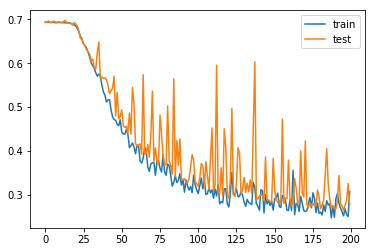

In [19]:
history1 = VanillaLSTM.fit(X_train, y_train, epochs=200, verbose=1, validation_data=(X_val,y_val), batch_size=batch_size)
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 3514 samples, validate on 1507 samples
Epoch 1/200
3514/3514 [==============================] - 2s 437us/step - loss: 0.6933 - accuracy: 0.5122 - val_loss: 0.6914 - val_accuracy: 0.5435
Epoch 2/200
3514/3514 [==============================] - 0s 140us/step - loss: 0.6937 - accuracy: 0.5020 - val_loss: 0.6948 - val_accuracy: 0.4565
Epoch 3/200
3514/3514 [==============================] - 0s 139us/step - loss: 0.6930 - accuracy: 0.5077 - val_loss: 0.7000 - val_accuracy: 0.4565
Epoch 4/200
3514/3514 [==============================] - 1s 161us/step - loss: 0.6940 - accuracy: 0.5057 - val_loss: 0.6936 - val_accuracy: 0.4565
Epoch 5/200
3514/3514 [==============================] - 1s 148us/step - loss: 0.6930 - accuracy: 0.5071 - val_loss: 0.6921 - val_accuracy: 0.5435
Epoch 6/200
3514/3514 [==============================] - 1s 148us/step - loss: 0.6932 - accuracy: 0.5043 - val_loss: 0.6945 - val_accuracy: 0.4565
Epoch 7/200
3514/3514 [==============================] - 1s 145us/step

3514/3514 [==============================] - 1s 151us/step - loss: 0.3220 - accuracy: 0.8944 - val_loss: 0.3399 - val_accuracy: 0.9429
Epoch 57/200
3514/3514 [==============================] - 0s 140us/step - loss: 0.3205 - accuracy: 0.8816 - val_loss: 0.3345 - val_accuracy: 0.9522
Epoch 58/200
3514/3514 [==============================] - 0s 136us/step - loss: 0.3212 - accuracy: 0.8819 - val_loss: 0.3322 - val_accuracy: 0.9317
Epoch 59/200
3514/3514 [==============================] - 0s 136us/step - loss: 0.3036 - accuracy: 0.9101 - val_loss: 0.3288 - val_accuracy: 0.9224
Epoch 60/200
3514/3514 [==============================] - 0s 134us/step - loss: 0.3110 - accuracy: 0.8828 - val_loss: 0.3219 - val_accuracy: 0.9615
Epoch 61/200
3514/3514 [==============================] - 0s 136us/step - loss: 0.3088 - accuracy: 0.8902 - val_loss: 0.3242 - val_accuracy: 0.9038
Epoch 62/200
3514/3514 [==============================] - 0s 133us/step - loss: 0.2953 - accuracy: 0.9067 - val_loss: 0.3708 

3514/3514 [==============================] - 0s 133us/step - loss: 0.2413 - accuracy: 0.9163 - val_loss: 0.2399 - val_accuracy: 0.9642
Epoch 112/200
3514/3514 [==============================] - 0s 132us/step - loss: 0.2433 - accuracy: 0.9109 - val_loss: 0.4879 - val_accuracy: 0.7306
Epoch 113/200
3514/3514 [==============================] - 0s 137us/step - loss: 0.2497 - accuracy: 0.9064 - val_loss: 0.3140 - val_accuracy: 0.8447
Epoch 114/200
3514/3514 [==============================] - 0s 135us/step - loss: 0.2199 - accuracy: 0.9360 - val_loss: 0.2414 - val_accuracy: 0.9575
Epoch 115/200
3514/3514 [==============================] - 0s 132us/step - loss: 0.2502 - accuracy: 0.9001 - val_loss: 0.2408 - val_accuracy: 0.9496
Epoch 116/200
3514/3514 [==============================] - 0s 130us/step - loss: 0.2348 - accuracy: 0.9149 - val_loss: 0.2740 - val_accuracy: 0.8806
Epoch 117/200
3514/3514 [==============================] - 0s 134us/step - loss: 0.2169 - accuracy: 0.9405 - val_loss: 0

3514/3514 [==============================] - 0s 134us/step - loss: 0.2054 - accuracy: 0.9417 - val_loss: 0.2218 - val_accuracy: 0.9522
Epoch 167/200
3514/3514 [==============================] - 0s 130us/step - loss: 0.2476 - accuracy: 0.9015 - val_loss: 0.3448 - val_accuracy: 0.8182
Epoch 168/200
3514/3514 [==============================] - 1s 144us/step - loss: 0.2073 - accuracy: 0.9382 - val_loss: 0.2238 - val_accuracy: 0.9496
Epoch 169/200
3514/3514 [==============================] - 0s 133us/step - loss: 0.2228 - accuracy: 0.9220 - val_loss: 0.3879 - val_accuracy: 0.7936
Epoch 170/200
3514/3514 [==============================] - 0s 129us/step - loss: 0.2142 - accuracy: 0.9286 - val_loss: 0.3709 - val_accuracy: 0.8016
Epoch 171/200
3514/3514 [==============================] - 0s 131us/step - loss: 0.2230 - accuracy: 0.9229 - val_loss: 0.2962 - val_accuracy: 0.8567
Epoch 172/200
3514/3514 [==============================] - 0s 130us/step - loss: 0.2039 - accuracy: 0.9448 - val_loss: 0

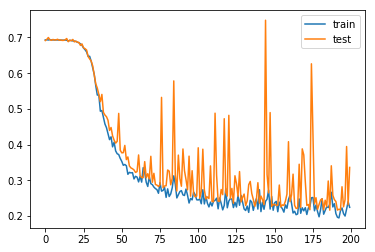

In [20]:
history2 = BidirectionalLSTM.fit(X_train, y_train, epochs=200, verbose=1, validation_data=(X_val,y_val), batch_size=batch_size)
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 3514 samples, validate on 1507 samples
Epoch 1/300
3514/3514 [==============================] - 0s 122us/step - loss: 0.6937 - accuracy: 0.5125 - val_loss: 0.7027 - val_accuracy: 0.4565
Epoch 2/300
3514/3514 [==============================] - 0s 58us/step - loss: 0.6927 - accuracy: 0.5040 - val_loss: 0.6877 - val_accuracy: 0.5435
Epoch 3/300
3514/3514 [==============================] - 0s 53us/step - loss: 0.6892 - accuracy: 0.5447 - val_loss: 0.7137 - val_accuracy: 0.4565
Epoch 4/300
3514/3514 [==============================] - 0s 55us/step - loss: 0.6896 - accuracy: 0.5137 - val_loss: 0.6917 - val_accuracy: 0.4579
Epoch 5/300
3514/3514 [==============================] - 0s 52us/step - loss: 0.6818 - accuracy: 0.5515 - val_loss: 0.6743 - val_accuracy: 0.5919
Epoch 6/300
3514/3514 [==============================] - 0s 55us/step - loss: 0.6686 - accuracy: 0.6030 - val_loss: 0.6722 - val_accuracy: 0.4891
Epoch 7/300
3514/3514 [==============================] - 0s 55us/step - los

3514/3514 [==============================] - 0s 51us/step - loss: 0.2106 - accuracy: 0.9143 - val_loss: 0.2629 - val_accuracy: 0.8653
Epoch 57/300
3514/3514 [==============================] - 0s 48us/step - loss: 0.1719 - accuracy: 0.9357 - val_loss: 0.2517 - val_accuracy: 0.8759
Epoch 58/300
3514/3514 [==============================] - 0s 50us/step - loss: 0.2467 - accuracy: 0.9087 - val_loss: 0.2085 - val_accuracy: 0.9423
Epoch 59/300
3514/3514 [==============================] - 0s 50us/step - loss: 0.1681 - accuracy: 0.9465 - val_loss: 0.1794 - val_accuracy: 0.9695
Epoch 60/300
3514/3514 [==============================] - 0s 49us/step - loss: 0.1630 - accuracy: 0.9394 - val_loss: 0.1858 - val_accuracy: 0.9509
Epoch 61/300
3514/3514 [==============================] - 0s 48us/step - loss: 0.2051 - accuracy: 0.9126 - val_loss: 0.2182 - val_accuracy: 0.9064
Epoch 62/300
3514/3514 [==============================] - 0s 54us/step - loss: 0.1671 - accuracy: 0.9411 - val_loss: 0.1754 - val_a

Epoch 112/300
3514/3514 [==============================] - 0s 61us/step - loss: 0.1556 - accuracy: 0.9351 - val_loss: 0.1618 - val_accuracy: 0.9549
Epoch 113/300
3514/3514 [==============================] - 0s 51us/step - loss: 0.1689 - accuracy: 0.9331 - val_loss: 0.1477 - val_accuracy: 0.9788
Epoch 114/300
3514/3514 [==============================] - 0s 48us/step - loss: 0.1559 - accuracy: 0.9417 - val_loss: 0.1483 - val_accuracy: 0.9754
Epoch 115/300
3514/3514 [==============================] - 0s 49us/step - loss: 0.1192 - accuracy: 0.9664 - val_loss: 0.1633 - val_accuracy: 0.9496
Epoch 116/300
3514/3514 [==============================] - 0s 49us/step - loss: 0.1400 - accuracy: 0.9471 - val_loss: 0.1474 - val_accuracy: 0.9642
Epoch 117/300
3514/3514 [==============================] - 0s 51us/step - loss: 0.1435 - accuracy: 0.9448 - val_loss: 0.1628 - val_accuracy: 0.9496
Epoch 118/300
3514/3514 [==============================] - 0s 50us/step - loss: 0.1943 - accuracy: 0.9195 - val_

3514/3514 [==============================] - 0s 51us/step - loss: 0.1711 - accuracy: 0.9314 - val_loss: 0.1981 - val_accuracy: 0.9137
Epoch 168/300
3514/3514 [==============================] - 0s 51us/step - loss: 0.1269 - accuracy: 0.9587 - val_loss: 0.1382 - val_accuracy: 0.9761
Epoch 169/300
3514/3514 [==============================] - 0s 49us/step - loss: 0.1289 - accuracy: 0.9519 - val_loss: 0.1704 - val_accuracy: 0.9336
Epoch 170/300
3514/3514 [==============================] - 0s 50us/step - loss: 0.2291 - accuracy: 0.9044 - val_loss: 0.1544 - val_accuracy: 0.9529
Epoch 171/300
3514/3514 [==============================] - 0s 50us/step - loss: 0.1468 - accuracy: 0.9454 - val_loss: 0.1395 - val_accuracy: 0.9808
Epoch 172/300
3514/3514 [==============================] - 0s 51us/step - loss: 0.1264 - accuracy: 0.9567 - val_loss: 0.1940 - val_accuracy: 0.9171
Epoch 173/300
3514/3514 [==============================] - 0s 51us/step - loss: 0.1377 - accuracy: 0.9459 - val_loss: 0.3591 -

3514/3514 [==============================] - 0s 50us/step - loss: 0.1611 - accuracy: 0.9320 - val_loss: 0.1882 - val_accuracy: 0.9190
Epoch 223/300
3514/3514 [==============================] - 0s 51us/step - loss: 0.1225 - accuracy: 0.9562 - val_loss: 0.1401 - val_accuracy: 0.9761
Epoch 224/300
3514/3514 [==============================] - 0s 51us/step - loss: 0.1187 - accuracy: 0.9604 - val_loss: 0.1441 - val_accuracy: 0.9622
Epoch 225/300
3514/3514 [==============================] - 0s 50us/step - loss: 0.1098 - accuracy: 0.9639 - val_loss: 0.1466 - val_accuracy: 0.9668
Epoch 226/300
3514/3514 [==============================] - 0s 49us/step - loss: 0.1686 - accuracy: 0.9323 - val_loss: 0.1477 - val_accuracy: 0.9642
Epoch 227/300
3514/3514 [==============================] - 0s 51us/step - loss: 0.1116 - accuracy: 0.9653 - val_loss: 0.1375 - val_accuracy: 0.9761
Epoch 228/300
3514/3514 [==============================] - 0s 49us/step - loss: 0.1283 - accuracy: 0.9505 - val_loss: 0.2605 -

3514/3514 [==============================] - 0s 48us/step - loss: 0.1209 - accuracy: 0.9482 - val_loss: 0.1329 - val_accuracy: 0.9575
Epoch 278/300
3514/3514 [==============================] - 0s 50us/step - loss: 0.1277 - accuracy: 0.9434 - val_loss: 0.2011 - val_accuracy: 0.9091
Epoch 279/300
3514/3514 [==============================] - 0s 51us/step - loss: 0.1018 - accuracy: 0.9610 - val_loss: 0.1211 - val_accuracy: 0.9794
Epoch 280/300
3514/3514 [==============================] - 0s 49us/step - loss: 0.1215 - accuracy: 0.9496 - val_loss: 0.1754 - val_accuracy: 0.9270
Epoch 281/300
3514/3514 [==============================] - 0s 51us/step - loss: 0.0919 - accuracy: 0.9707 - val_loss: 0.1211 - val_accuracy: 0.9695
Epoch 282/300
3514/3514 [==============================] - 0s 50us/step - loss: 0.1098 - accuracy: 0.9604 - val_loss: 0.1494 - val_accuracy: 0.9443
Epoch 283/300
3514/3514 [==============================] - 0s 52us/step - loss: 0.1049 - accuracy: 0.9579 - val_loss: 0.1351 -

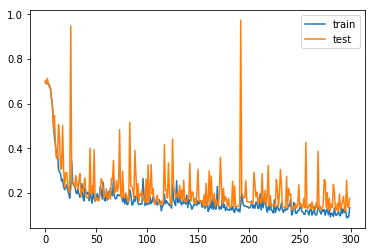

In [53]:
history3 = CNN.fit(X_train, y_train, epochs=300, verbose=1, validation_data=(X_val,y_val), batch_size=batch_size)
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='test')
plt.legend()
plt.show()